In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping

In [3]:
def get_clf_eval(y_test,pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred, average = 'macro')
    recall = recall_score(y_test,pred, average = 'macro')
    f1 = f1_score(y_test, pred, average = 'macro')
    roc_auc = roc_auc_score(y_test, pred_proba, average = 'macro', multi_class='ovr')
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 1. Load train and test data

In [4]:
train_data = pd.read_csv("data/train_data_PCA.csv", header=None)
test_data = pd.read_csv("data/test_data_PCA.csv", header=None)

X_train = train_data.iloc[:,:2]
y_train = train_data.iloc[:,2]

X_test = test_data.iloc[:,:2]
y_test = test_data.iloc[:,2]

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

### 2. Training the DNN model

In [5]:
train_set = pd.DataFrame(X_train_scaled)
train_set.loc[:,'Target'] = y_train

In [6]:
test_set = pd.DataFrame(X_test_scaled)
test_set.loc[:,'Target'] = y_test

In [8]:
from keras.utils import np_utils
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

DNN_accuracy = []
cond_accuracy = []
avg_accuracy = []
best_score = 0
order = 0
n_hidden_nodes = [10, 20, 30, 40]
n = {0, 1, 2, 3}

for nodes in n_hidden_nodes:
    
    print("n_hidden_nodes:", nodes)
    
    for train, valid in skf.split(train_set, train_set["Target"]):
        
        order = order + 1
        
        print("The order of 5-fold cross-validation:", order)
        
        strat_k_train_set = train_set.iloc[train]
        strat_k_valid_set = train_set.iloc[valid]

        X_train = strat_k_train_set.drop(["Target"], axis=1)
        X_valid = strat_k_valid_set.drop(["Target"], axis=1)
        y_train = strat_k_train_set["Target"].copy()
        y_valid = strat_k_valid_set["Target"].copy()
        
        
        y_train_encoded = np_utils.to_categorical(y_train)
        y_valid_encoded = np_utils.to_categorical(y_valid)
        
        # DNN model configuration
        model = Sequential()
        model.add(Dense(nodes, input_dim=2, activation='relu'))
        model.add(Dense(nodes, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping_callback = EarlyStopping(monitor='loss', patience=100, verbose=0)
        
        
        model.fit(X_train,y_train_encoded, validation_data=(X_valid, y_valid_encoded), epochs=500, 
                  batch_size=5, verbose=0, callbacks=[early_stopping_callback])
        accuracy = model.evaluate(X_valid,y_valid_encoded)[1]
        DNN_accuracy.append(accuracy)
             
    avg_accuracy = sum(DNN_accuracy)/len(DNN_accuracy)
    cond_accuracy.append(avg_accuracy)
    DNN_accuracy = []
    
    if best_score < avg_accuracy:
        best_score = avg_accuracy
        best_parameters = {'n_hidden_nodes': nodes}
        best_model = model

    order = 0

for i in n:
    print("number of hidden nodes:", n_hidden_nodes[i], ", Average accuracy: {:.4f}".format(cond_accuracy[i]))

print("Best parameters:", best_parameters)
print("Highest accuracy: {:.4f}".format(best_score))

n_hidden_nodes: 10
The order of 5-fold cross-validation: 1
45/45 [==============================] - 0s 467us/step - loss: 0.2288 - accuracy: 0.9139
The order of 5-fold cross-validation: 2
45/45 [==============================] - 0s 467us/step - loss: 0.2599 - accuracy: 0.9056
The order of 5-fold cross-validation: 3
45/45 [==============================] - 0s 844us/step - loss: 0.2412 - accuracy: 0.9174
The order of 5-fold cross-validation: 4
45/45 [==============================] - 0s 467us/step - loss: 0.2408 - accuracy: 0.9167
The order of 5-fold cross-validation: 5
45/45 [==============================] - 0s 422us/step - loss: 0.2305 - accuracy: 0.9222
n_hidden_nodes: 20
The order of 5-fold cross-validation: 1
45/45 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.9139
The order of 5-fold cross-validation: 2
45/45 [==============================] - 0s 400us/step - loss: 0.2590 - accuracy: 0.9076
The order of 5-fold cross-validation: 3
45/45 [==============

### 3. Test the DNN model

In [9]:
X_train = train_set.iloc[:,:2]
y_train = train_set.iloc[:,2]

X_test = test_set.iloc[:,:2]
y_test = test_set.iloc[:,2]

y_train_encoded = np_utils.to_categorical(y_train)
y_test_encoded = np_utils.to_categorical(y_test)

In [15]:
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
model.fit(X_train,y_train_encoded, epochs=500, batch_size=5, verbose=0)
accuracy = model.evaluate(X_test,y_test_encoded)[1]

print("accuracy for predicting test data: {:.4f}".format(accuracy)) 

17/17 [==============================] - 0s 471us/step - loss: 0.3367 - accuracy: 0.8724
accuracy for predicting test data: 0.8724


In [16]:
preds = model.predict(X_test)
preds_decod = np.argmax(preds, axis=1).reshape(-1,1)
get_clf_eval(y_test, preds_decod, preds)

Confusion matrix
[[109   0  27  16]
 [  0 120  15   0]
 [  4   5 110   1]
 [  0   0   0 126]]
Accuracy:0.8724, Precision:0.8824, Recall:0.8807, F1:0.8728, AUC:0.9832


In [17]:
print(metrics.classification_report(y_test, preds_decod, digits=4))

              precision    recall  f1-score   support

           0     0.9646    0.7171    0.8226       152
           1     0.9600    0.8889    0.9231       135
           2     0.7237    0.9167    0.8088       120
           3     0.8811    1.0000    0.9368       126

    accuracy                         0.8724       533
   macro avg     0.8824    0.8807    0.8728       533
weighted avg     0.8895    0.8724    0.8720       533



In [18]:
test_preds = preds_decod.reshape(-1)

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 10 Text xticklabel objects>)

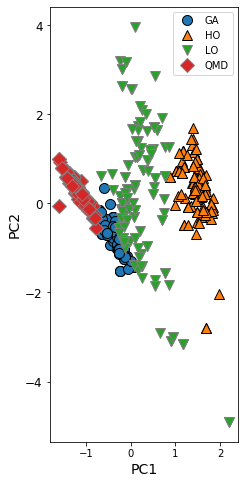

In [19]:
import mglearn

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_test_scaled[:,0], X_test_scaled[:,1], test_preds)
plt.legend(["GA", "HO", "LO", "QMD"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xticks(fontsize=10)